Loading packages and data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp
from scipy import stats

In [2]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "measurements_b3_2.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="metafile_niacin_2")

grouping the animals and exploring the data frame

In [3]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'experimental':
        return 1
    elif row['sex'] == 'male' and row['diet'] == 'control':
        return 2
    elif row['sex'] == 'male' and row['diet'] == 'experimental':
        return 3
    else:
        return -1

def tweak_df(df):
    
    return (df
            # .query("bodyweight != ''")
            .query("bodyweight.notna()", engine="python")
            .astype({"sex": "category",
                     "diet": "category",
                     "bodyweight": float,
                     "food_yesterday": float,
                     "food_intake": float,
                     "sucrose_intake": float
                     }
                    )
             .assign(groupn = lambda df_: df_.apply(get_value, axis=1))
            )
    
df = tweak_df(pd.DataFrame(rows, columns=header))

In [4]:
df

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,groupn
0,B3201,female,control,2024-04-06,no,20.6,-1.0,80.8,-1.000000,-1.0,-1.0,-1.0,0
1,B3202,female,control,2024-04-06,no,21.0,-1.0,98.6,-1.000000,-1.0,-1.0,-1.0,0
2,B3203,female,experimental,2024-04-06,no,21.2,-1.0,139.3,-1.000000,-1.0,-1.0,-1.0,1
3,B3204,female,experimental,2024-04-06,no,20.4,-1.0,139.3,-1.000000,-1.0,-1.0,-1.0,1
4,B3205,female,control,2024-04-06,no,19.8,-1.0,80.2,-1.000000,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,B3244,male,experimental,2024-04-09,no,25.7,89.5,80.4,3.033333,-1.0,-1.0,-1.0,3
92,B3245,male,experimental,2024-04-09,no,24.3,64.8,55.4,3.133333,-1.0,-1.0,-1.0,3
93,B3246,male,experimental,2024-04-09,no,26.2,90.0,79.9,3.366667,-1.0,-1.0,-1.0,3
94,B3247,male,experimental,2024-04-09,no,26.2,82.4,73.7,2.900000,-1.0,-1.0,-1.0,3


In [5]:
df.dtypes

animal_id                    object
sex                        category
diet                       category
date                 datetime64[ns]
sucrose                      object
bodyweight                  float64
food_yesterday              float64
food_today                  float64
food_intake                 float64
sucrose_yesterday           float64
sucrose_today               float64
sucrose_intake              float64
groupn                        int64
dtype: object

In [6]:
df.columns

Index(['animal_id', 'sex', 'diet', 'date', 'sucrose', 'bodyweight',
       'food_yesterday', 'food_today', 'food_intake', 'sucrose_yesterday',
       'sucrose_today', 'sucrose_intake', 'groupn'],
      dtype='object')

In [16]:
df.animal_id.unique()
df.date.unique()

<DatetimeArray>
['2024-04-06 00:00:00', '2024-04-09 00:00:00']
Length: 2, dtype: datetime64[ns]

Timestamp('2024-04-09 00:00:00')

In [8]:
df.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()

,sex,diet,date,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,groupn
0,female,control,2024-04-06,20.625000,-1.000000,79.458333,-1.000000,-1.0,-1.0,-1.0,0.0
1,female,control,2024-04-09,20.466667,79.458333,69.700000,2.752778,-1.0,-1.0,-1.0,0.0
2,female,experimental,2024-04-06,20.725000,-1.000000,87.141667,-1.000000,-1.0,-1.0,-1.0,1.0
3,female,experimental,2024-04-09,20.733333,87.141667,77.216667,2.869444,-1.0,-1.0,-1.0,1.0
4,male,control,2024-04-06,25.716667,-1.000000,63.650000,-1.000000,-1.0,-1.0,-1.0,2.0
5,male,control,2024-04-09,25.608333,63.650000,54.050000,3.200000,-1.0,-1.0,-1.0,2.0
6,male,experimental,2024-04-06,25.600000,-1.000000,80.091667,-1.000000,-1.0,-1.0,-1.0,3.0
7,male,experimental,2024-04-09,25.591667,80.091667,70.550000,3.180556,-1.0,-1.0,-1.0,3.0


In [9]:
# remove outliers
# is done by creating the new dataframe df_food_water
# Clean up df


def replace_outliers(df, column):
    
    values=[]
    for idx, row in df.iterrows():
        if row[column] < 1:
            values.append(np.nan)
        elif row[column] > np.mean(df[column]) * 2:
            values.append(np.nan)
        else:
            values.append(row[column])
    
    print("the number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df[column] = values
    mean_by_animal = df.groupby(["animal_id"]).mean(numeric_only=True).reset_index()
            
    values=[]
    for idx, row in df.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])
    
    return values
    
def remove_and_clean(df):
    """Removes unecessary rows and cleans data to get rid of erroneous values.

    Args:
        df (Pandas dataframe): Contains data from niacin experiment

    Returns:
        Dataframe: Cleaned dataframe
    """
    return (df
            .query("food_yesterday != -1.0")
            
            .assign(food_intake = lambda df_: replace_outliers(df_, "food_intake"))
            .assign(sucrose_intake = lambda df_: replace_outliers(df_, "sucrose_intake"))
    )

df_food_water = remove_and_clean(df)

the number of outliers being replaced for food_intake is 0
the number of outliers being replaced for sucrose_intake is 48


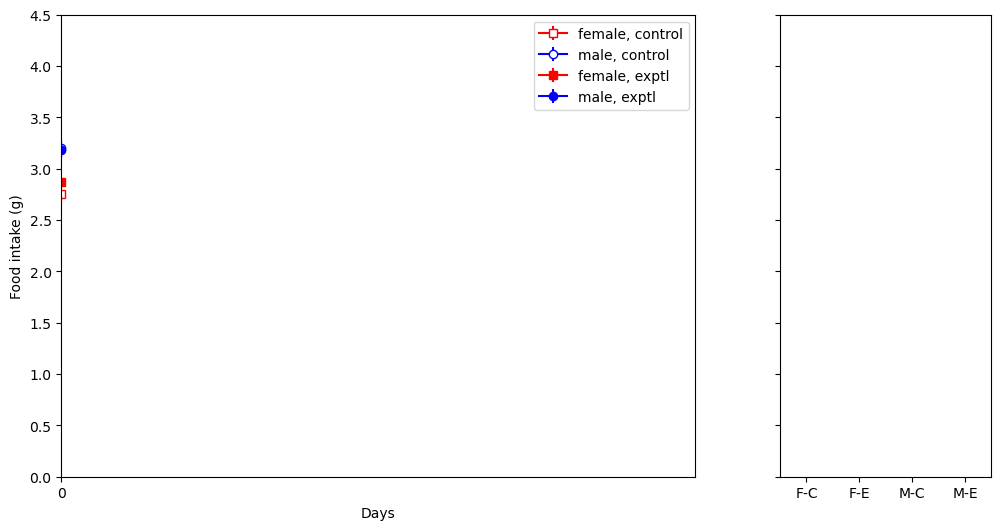

In [12]:
# Find mean and SEM of all data for before split
mean_fw = df_food_water.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [3, 1]},)

# Set x values
x = np.arange(int(len(mean_fw.date) / 4))

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="white", color="red",
               label="female, control"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'male' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="male, control"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and diet == 'experimental'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="female, exptl"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'male' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="blue", color="blue",
               label="male, exptl"
              )

# Set x axis limits and ticks
ax[0].set_xlim([0,1])
ax[0].set_xticks(np.arange(0, 7, 7)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Food intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()

# Plot today's data in second subplot
today = df_food_water.date.max()
today_df = df_food_water.query("date == @today")

palette = ["red", "red", "blue", "blue"]

sns.stripplot(data=today_df, x="groupn", y="bodyweight", hue="groupn", palette=palette, ax=ax[1])
sns.pointplot(data=today_df, x='groupn', y='bodyweight', capsize=.2, color="grey", markers='o', join=False, ax=ax[1])

ax[1].set_xticklabels(["F-C", "F-E", "M-C", "M-E"])
ax[1].set_xlabel("")
ax[1].set_ylabel("Bodyweight (g)")
ax[1].legend().remove()
